# Group 8 ML Project: Predicting Hotel Reservation Cancellations 

In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA   
import seaborn as sns 
import matplotlib.pyplot as plt
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score

import openpyxl

## Data Cleaning 

Import the data and do some data processing

In [2]:
# Read data
filename = 'Hotel_Reservations.csv'
df = pd.read_csv(filename) #it has two sheets, we load the 2nd one
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


We first need to remove useless variables and null values (or impute them) since KNN in scikit does not handle them. In this case there are no useless variables to discard, so we will check for nulls.

In [3]:
df.isnull().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

Since there are no null values, we can proceed with the data cleaning

In [4]:
#We set the Booking ID as the index - so we can then keep track of each booking
df.set_index('Booking_ID', inplace=True)

We check for all unique values in categorical variables to see if we should conduct one-hot encoding or convert to numerical (if the categories are ordinal)

In [5]:
#Check for all unique values in market_segment_type
df['market_segment_type'].unique()

array(['Offline', 'Online', 'Corporate', 'Aviation', 'Complementary'],
      dtype=object)

In [6]:
#Check for all unique values in room_type_reserved
df['room_type_reserved'].unique()

array(['Room_Type 1', 'Room_Type 4', 'Room_Type 2', 'Room_Type 6',
       'Room_Type 5', 'Room_Type 7', 'Room_Type 3'], dtype=object)

In [7]:
#Check for all unique values in type_of_meal_plan
df['type_of_meal_plan'].unique()

array(['Meal Plan 1', 'Not Selected', 'Meal Plan 2', 'Meal Plan 3'],
      dtype=object)

We will proceed with one-hot encoding of market_segment_type and type_of_meal_plan, while convering room_type_reserved values to numbers assuming that the room types are ordinal and the distance between Room Type 1 and Room Type 4 should not be the same. 

In [8]:
# One-hot encoding
df = pd.get_dummies(df, columns=['market_segment_type'], prefix='segment')

# Display the first few rows
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,...,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,segment_Aviation,segment_Complementary,segment_Corporate,segment_Offline,segment_Online
Booking_ID,,,,,,,,,,,,,,,,,,,,,
INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,...,0,0,65.00,0,Not_Canceled,False,False,False,True,False
INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,...,0,0,106.68,1,Not_Canceled,False,False,False,False,True
INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,...,0,0,60.00,0,Canceled,False,False,False,False,True
INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,...,0,0,100.00,0,Canceled,False,False,False,False,True
INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,...,0,0,94.50,0,Canceled,False,False,False,False,True


In [9]:
# One-hot encoding for 'type_of_meal_plan'
df = pd.get_dummies(df, columns=['type_of_meal_plan'], prefix='meal_plan')

# Display the first few rows
df.head()


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,...,booking_status,segment_Aviation,segment_Complementary,segment_Corporate,segment_Offline,segment_Online,meal_plan_Meal Plan 1,meal_plan_Meal Plan 2,meal_plan_Meal Plan 3,meal_plan_Not Selected
Booking_ID,,,,,,,,,,,,,,,,,,,,,
INN00001,2,0,1,2,0,Room_Type 1,224,2017,10,2,...,Not_Canceled,False,False,False,True,False,True,False,False,False
INN00002,2,0,2,3,0,Room_Type 1,5,2018,11,6,...,Not_Canceled,False,False,False,False,True,False,False,False,True
INN00003,1,0,2,1,0,Room_Type 1,1,2018,2,28,...,Canceled,False,False,False,False,True,True,False,False,False
INN00004,2,0,0,2,0,Room_Type 1,211,2018,5,20,...,Canceled,False,False,False,False,True,True,False,False,False
INN00005,2,0,1,1,0,Room_Type 1,48,2018,4,11,...,Canceled,False,False,False,False,True,False,False,False,True


In [10]:
# Extract the numerical part from 'Room_Type X' -- since we assume that the room types are ordinal
df['room_type_reserved'] = df['room_type_reserved'].str.extract('(\d+)').astype(int)

# Display unique values after transformation
df['room_type_reserved'].unique()

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\bburg\AppData\Local\Temp\ipykernel_16008\777233012.py:2: SyntaxWarning: invalid escape sequence '\d'
  df['room_type_reserved'] = df['room_type_reserved'].str.extract('(\d+)').astype(int)


array([1, 4, 2, 6, 5, 7, 3])

We will also create a binary target variable "booking_canceled" determining whether the booking was cancelled or not 

In [11]:
df['booking_canceled'] = df['booking_status'].replace({'Canceled': 1, 'Not_Canceled': 0})

# Display unique values after transformation
df['booking_canceled'].unique()

C:\Users\bburg\AppData\Local\Temp\ipykernel_16008\2682574745.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['booking_canceled'] = df['booking_status'].replace({'Canceled': 1, 'Not_Canceled': 0})


array([0, 1], dtype=int64)

In [12]:
df.drop(columns=['booking_status'], inplace=True)


In [13]:
#Features left for analysis 
df.columns

Index(['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'required_car_parking_space', 'room_type_reserved',
       'lead_time', 'arrival_year', 'arrival_month', 'arrival_date',
       'repeated_guest', 'no_of_previous_cancellations',
       'no_of_previous_bookings_not_canceled', 'avg_price_per_room',
       'no_of_special_requests', 'segment_Aviation', 'segment_Complementary',
       'segment_Corporate', 'segment_Offline', 'segment_Online',
       'meal_plan_Meal Plan 1', 'meal_plan_Meal Plan 2',
       'meal_plan_Meal Plan 3', 'meal_plan_Not Selected', 'booking_canceled'],
      dtype='object')

## Exploratory Data Analysis (EDA) of the Hotel Reservations dataset

In [14]:
#Exploratory data analysis
df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_canceled
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,1.708890,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655,0.327636
std,0.518715,0.402648,0.870644,1.410905,0.173281,1.399851,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236,0.469358
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,1.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,1.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,7.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000,1.000000


Very important to **standardize** the data!

In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

target = df["booking_canceled"] #we select the target variable before standardizing the data

columns = df.columns
standard_scaler = StandardScaler()
data = pd.DataFrame(standard_scaler.fit_transform(df), columns=df.columns)
data

#min_max_scaler = MinMaxScaler() - Another option
#data = min_max_scaler.fit_transform(data)



,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,...,segment_Aviation,segment_Complementary,segment_Corporate,segment_Offline,segment_Online,meal_plan_Meal Plan 1,meal_plan_Meal Plan 2,meal_plan_Meal Plan 3,meal_plan_Not Selected,booking_canceled
0,0.298893,-0.26147,0.217401,-0.144803,-0.178819,-0.506411,1.614896,-2.137469,0.839242,-1.555662,...,-0.058803,-0.104385,-0.242645,1.563833,-1.333174,0.550650,-0.316611,-0.011741,-0.405849,-0.698062
1,0.298893,-0.26147,1.365993,0.563972,-0.178819,-0.506411,-0.933701,0.467843,1.164990,-1.098013,...,-0.058803,-0.104385,-0.242645,-0.639454,0.750090,-1.816036,-0.316611,-0.011741,2.463970,-0.698062
2,-1.628975,-0.26147,1.365993,-0.853578,-0.178819,-0.506411,-0.980250,0.467843,-1.766747,1.419055,...,-0.058803,-0.104385,-0.242645,-0.639454,0.750090,0.550650,-0.316611,-0.011741,-0.405849,1.432539
3,0.298893,-0.26147,-0.931190,-0.144803,-0.178819,-0.506411,1.463610,0.467843,-0.789501,0.503757,...,-0.058803,-0.104385,-0.242645,-0.639454,0.750090,0.550650,-0.316611,-0.011741,-0.405849,1.432539
4,0.298893,-0.26147,0.217401,-0.853578,-0.178819,-0.506411,-0.433291,0.467843,-1.115250,-0.525952,...,-0.058803,-0.104385,-0.242645,-0.639454,0.750090,-1.816036,-0.316611,-0.011741,2.463970,1.432539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,2.226761,-0.26147,1.365993,2.690296,-0.178819,1.636704,-0.002706,0.467843,0.187744,-1.441250,...,-0.058803,-0.104385,-0.242645,-0.639454,0.750090,0.550650,-0.316611,-0.011741,-0.405849,-0.698062
36271,0.298893,-0.26147,0.217401,0.563972,-0.178819,-0.506411,1.661446,0.467843,0.839242,0.160521,...,-0.058803,-0.104385,-0.242645,-0.639454,0.750090,0.550650,-0.316611,-0.011741,-0.405849,1.432539
36272,0.298893,-0.26147,1.365993,2.690296,-0.178819,-0.506411,0.730452,0.467843,-0.138004,-1.670074,...,-0.058803,-0.104385,-0.242645,-0.639454,0.750090,0.550650,-0.316611,-0.011741,-0.405849,-0.698062
36273,0.298893,-0.26147,-0.931190,0.563972,-0.178819,-0.506411,-0.258730,0.467843,-1.115250,0.618170,...,-0.058803,-0.104385,-0.242645,-0.639454,0.750090,-1.816036,-0.316611,-0.011741,2.463970,1.432539


And show pie chart with classes

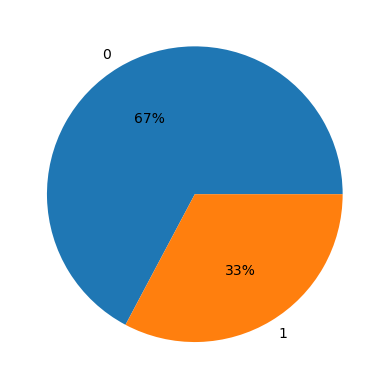

In [16]:
unique, counts = np.unique(target, return_counts=True)
plt.pie(counts, labels=unique, autopct='%.0f%%');

<Axes: >

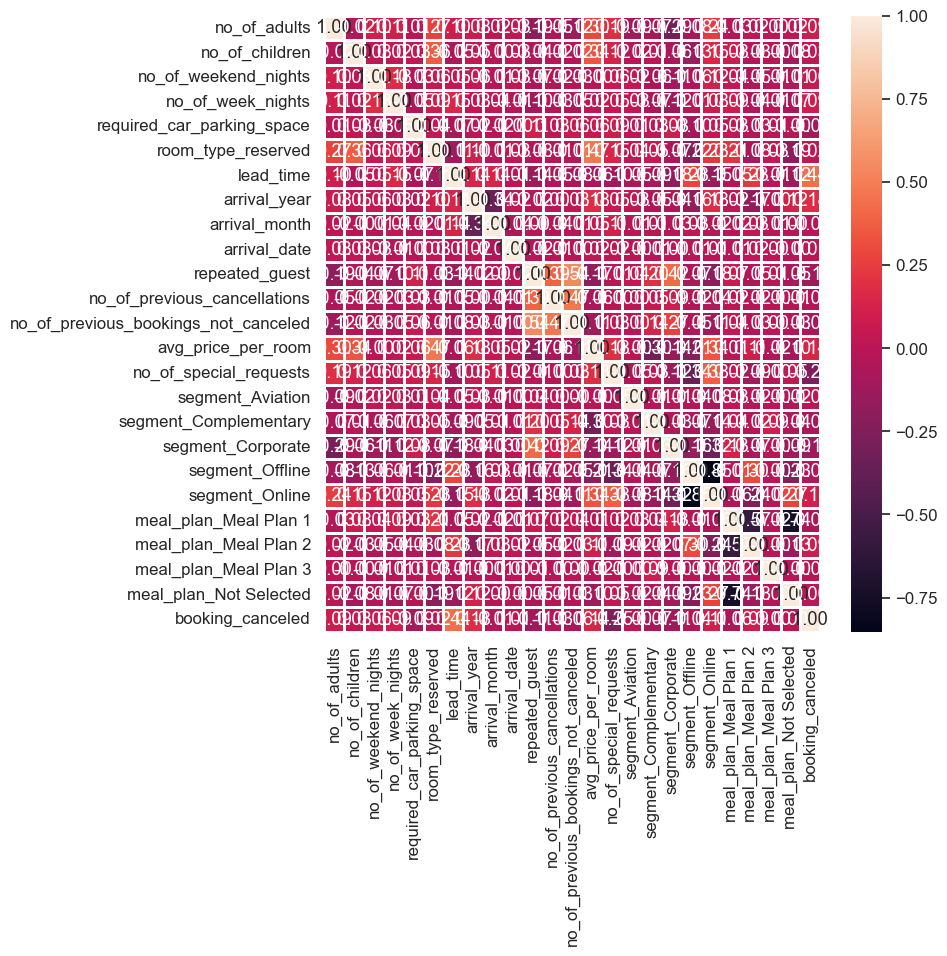

In [17]:
# Heatmap to show correlation between explanatory variables
sns.set(font_scale=1.1)
fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
sns.heatmap(df.corr(), annot=True, fmt=".2f", linewidths=1, ax=ax)

We analyzed feature importance to understand the most relevant factors influencing hotel reservation cancellations. 

In [ ]:
#TO DO 

## Bagging Model to predict hotel reservation cancellations - ABDULLAH

In [ ]:
#TO DO

## Random Forest Model to predict hotel reservation cancellations - LOUIS-ESMEL

In [ ]:
#TO DO

## Boosting Model to predict hotel reservation cancellations - SPENCER

In [ ]:
#TO DO

## KNN Model to predict hotel reservation cancellations

Now we create a function to do the data splitting, that we will use in a short while

In [19]:
from sklearn.model_selection import train_test_split 

# Train and test sets
def split_data(data, ratio):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=ratio, stratify=target)
    X_train.drop('booking_canceled', axis=1, inplace=True)
    X_test.drop('booking_canceled', axis=1, inplace=True)
    return X_train, X_test, y_train, y_test

^^ Stratify is used to create balanced samples around the target variable

### KNN model 1

First example with k=5

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=5) # we don´t know yet the optimal number of neighbours

X_train, X_test, y_train, y_test = split_data(data, 0.2) 
print(X_train.shape)
print(X_test.shape)

(29020, 24)
(7255, 24)


In [21]:
knn_classifier.fit(X_train, y_train)

# Predictions (on test set, obviously)
knn_predictions = knn_classifier.predict(X_test)

# Calculate error_rate and print it
error_rate = 1 - accuracy_score(y_test, knn_predictions)
print("% Error (k=5): {0:.1%}".format(error_rate))

% Error (k=5): 15.1%


### Look for best option of  k (manually)

The idea now is to compare different splits and k values (hyper parameter), so we need a error measure calculation (1-accuracy), of course on the test set

In [22]:
def measure_error(num_iterations, K, ratio):
    perf = np.ones(num_iterations)
    for i in range(num_iterations):
        np.random.seed(i)
        X_train, X_test, y_train, y_test = split_data(data, ratio)
        knn_classifier = KNeighborsClassifier(n_neighbors=K)
        knn_classifier.fit(X_train, y_train)
        knn_predictions = knn_classifier.predict(X_test)
        error_rate = 1 - accuracy_score(y_test, knn_predictions)
        perf[i] = error_rate
    return np.mean(perf)

Now we produce several models, each with a different split between train and test set (from 50% train set to 90%), <BR>with different neighours values (from 5 to 15) and compare the errors of all them.
<BR>(we run it on 10 iterations to have it quicker, but normally from 50 is best)    

ratio (train set): 0.5
Neighbours: 5 , error: 0.1596
Neighbours: 6 , error: 0.1589
Neighbours: 7 , error: 0.1591
Neighbours: 8 , error: 0.1603
Neighbours: 9 , error: 0.1596
Neighbours: 10 , error: 0.1611
Neighbours: 11 , error: 0.1616
Neighbours: 12 , error: 0.1624
Neighbours: 13 , error: 0.1623
Neighbours: 14 , error: 0.163
Neighbours: 15 , error: 0.1637
Neighbours: 16 , error: 0.1643
Neighbours: 17 , error: 0.1645
Neighbours: 18 , error: 0.1661
Neighbours: 19 , error: 0.1665
Neighbours: 20 , error: 0.1661
Neighbours: 21 , error: 0.1663
Neighbours: 22 , error: 0.1671
Neighbours: 23 , error: 0.1675
Neighbours: 24 , error: 0.168
Neighbours: 25 , error: 0.1683
Neighbours: 26 , error: 0.168
Neighbours: 27 , error: 0.1683
Neighbours: 28 , error: 0.1685
Neighbours: 29 , error: 0.1688
Neighbours: 30 , error: 0.1693
Neighbours: 31 , error: 0.169
Neighbours: 32 , error: 0.1692
Neighbours: 33 , error: 0.1694
Neighbours: 34 , error: 0.1701
Neighbours: 35 , error: 0.1704
Neighbours: 36 , error: 0

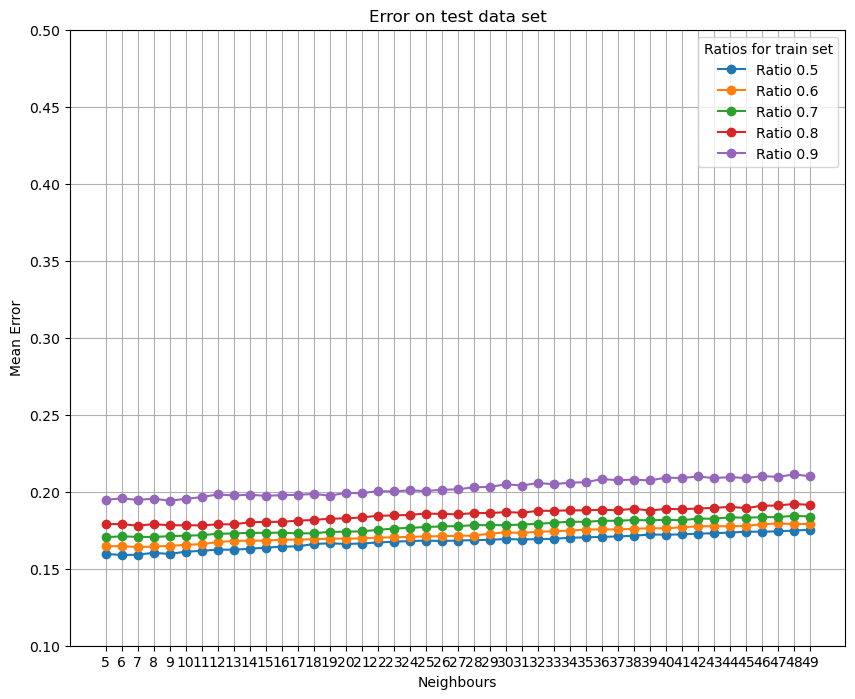

In [ ]:
ratios = np.arange(0.5, 1.0, 0.1)
k_values = np.arange(5, 50)

plt.figure(figsize=(10, 8))
plt.xlabel("Neighbours")
plt.ylabel("Mean Error")

for ratio in ratios:
    print("ratio (train set):", np.round(ratio,2))
    mean_error=[]
    for K in k_values:
        error=measure_error(10, K, ratio) #10 iterations
        print("Neighbours:", K, ", error:", np.round(error,4))
        mean_error.append(error)
    
    plt.plot(k_values, mean_error, marker='o', label=f"Ratio {np.round(ratio,2)}")

plt.title("Error on test data set")
plt.legend(title="Ratios for train set")
plt.xticks(k_values)
plt.ylim(0.1, 0.25)
plt.grid(True)
plt.show()

And we can see that error starts to increase (with best ratio) from 7 neighbours approx. 
<BR>We can apply these values to our model and test

In [25]:
#take the lowest error combination
knn_classifier = KNeighborsClassifier(n_neighbors=7) 
X_train, X_test, y_train, y_test = split_data(data, 0.5) 
knn_classifier.fit(X_train, y_train)

knn_predictions = knn_classifier.predict(X_test)

error_rate = 1 - accuracy_score(y_test, knn_predictions)
print("% Error (k=8): {0:.1%}".format(error_rate))

% Error (k=8): 15.6%


### KNN model 2 (with grid search)

First you need to search for the optimal train-test split (usually 50%-50%) and then you run the grid search for parameters 

Second model, now we are looking for the best k parameter (from 1 to 12) and also the best weighting scheme from the two available <BR>(it is also possible to customize it in sklearn)

In [26]:
# Grid search for hyperparameters
from sklearn.model_selection import GridSearchCV

parameters = {
    "n_neighbors": range(1, 12),
    "weights": ["uniform", "distance"] # try with both options
}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train) 

GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parameters)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 12),
                         'weights': ['uniform', 'distance']})

What are the best parameters found in the training dataset?

In [27]:
gridsearch.best_params_ #includes the weighting scheme 

{'n_neighbors': 9, 'weights': 'distance'}

And obviously we now apply those values found, fit the model and make predictions

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_recall_curve, confusion_matrix, recall_score, precision_score

# Apply prediction 
train_preds_grid = gridsearch.predict(X_train)

gridpredictions = gridsearch.predict(X_test) #probability of being in both groups
error_rate = 1 - accuracy_score(y_test, gridpredictions)
print("% Error (grid search): {0:.1%}".format(error_rate))

% Error (grid search): 13.6%


^^ we find the best parameters and then we can use it to predict -- saves automatically 

We now create the ROC curve

Train Accuracy score:  99.45 %
Test Accuracy score:  86.38 %


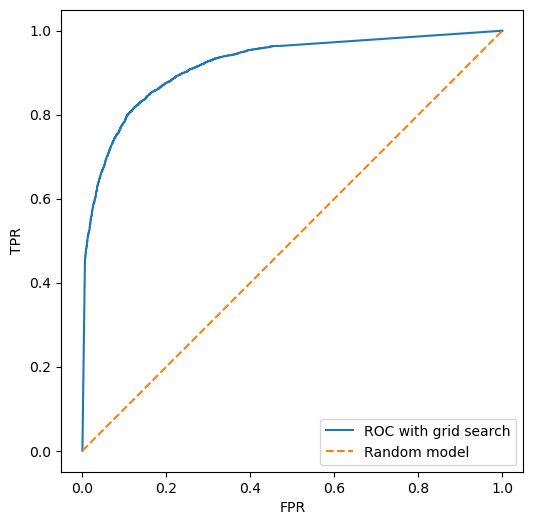

In [29]:
pred_prob = gridsearch.predict_proba(X_test) #probability of being in both groups
prob_1 = [p[1] for p in pred_prob] #probability of being in the survived group

auc = roc_auc_score(y_test, prob_1)

fpr, tpr, thresholds = roc_curve(y_test, prob_1, pos_label=1)

train_acc = round(gridsearch.score(X_train,y_train) * 100,2) #Train Accuracy score
test_acc = round(gridsearch.score(X_test,y_test) * 100,2) #Test Accuracy score
print("Train Accuracy score: ", train_acc, "%")
print("Test Accuracy score: ", test_acc, "%")

# ROC curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(fpr, tpr, label="ROC with grid search")
ax.plot([0, 1], [0, 1],linestyle='--', label="Random model") 
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_box_aspect(1)
ax.legend()
plt.show()

And confusion matrix

Confusion Matrix


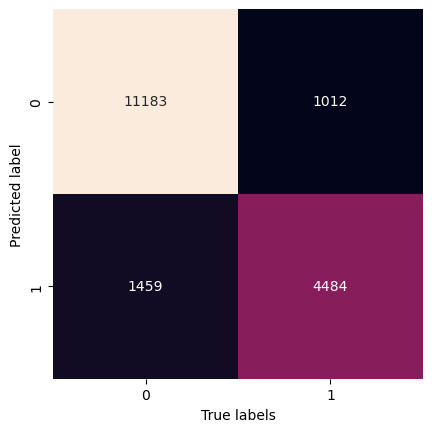

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Confusion Matrix")
conf_mat = confusion_matrix(y_test, gridpredictions)

# Draw heatmap using confusion matrix
sns.heatmap(conf_mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True labels')
plt.ylabel('Predicted label');

^^^by default it uses 50% threshold -- later we will see how to change it 

### KNN model 3 (bagging classifier)

In the last model we are implementing some bagging to KNN (using best parameters found with grid search)

In [31]:
best_k = gridsearch.best_params_["n_neighbors"]
best_weights = gridsearch.best_params_["weights"]

# this is the bagged model we will use
bagged_knn = KNeighborsClassifier( 
    n_neighbors=best_k, weights=best_weights
)

The method has many options, we are using here BaggingClassifier with 100 estimators

In [32]:
from sklearn.ensemble import BaggingClassifier

knnbagging_model = BaggingClassifier(bagged_knn, n_estimators=100) 
knnbagging_model.fit(X_train, y_train)

BaggingClassifier(estimator=KNeighborsClassifier(n_neighbors=9,
                                                 weights='distance'),
                  n_estimators=100)

And evaluate results with ROC curve and confusion matrix

Train Accuracy score:  99.45 %
Test Accuracy score:  86.54 %


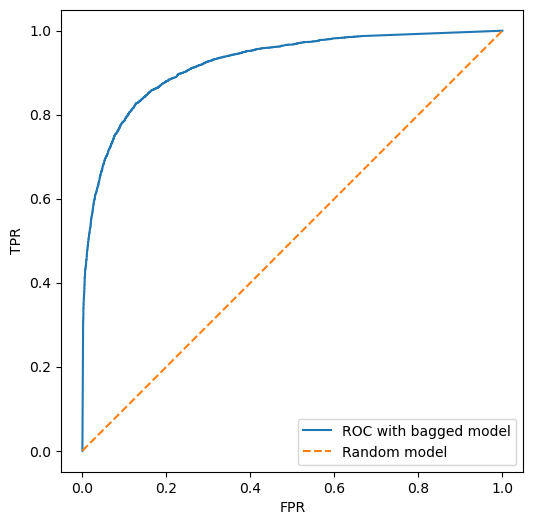

In [33]:
test_preds_grid = knnbagging_model.predict(X_test)

predictions = knnbagging_model.predict(X_test) 
pred_prob = knnbagging_model.predict_proba(X_test) #probability of being in both groups
prob_1 = [p[1] for p in pred_prob] #probability of being in the malign group
auc = roc_auc_score(y_test, prob_1)

fpr, tpr, thresholds = roc_curve(y_test, prob_1, pos_label=1)

train_acc = round(knnbagging_model.score(X_train,y_train) * 100,2) #Train Accuracy score
test_acc = round(knnbagging_model.score(X_test,y_test) * 100,2) #Test Accuracy score
print("Train Accuracy score: ", train_acc, "%")
print("Test Accuracy score: ", test_acc, "%")

# ROC curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(fpr, tpr, label="ROC with bagged model")
ax.plot([0, 1], [0, 1],linestyle='--', label="Random model") 
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_box_aspect(1)
ax.legend()
plt.show()

^^^didn't improve much using bagging 

Confusion Matrix


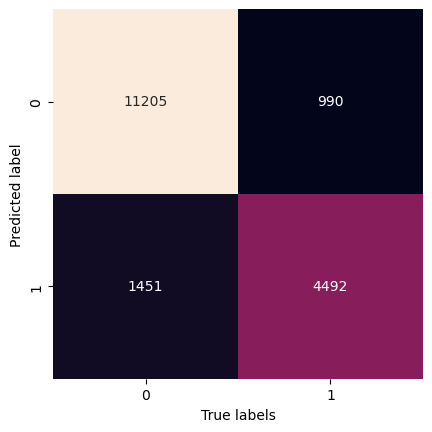

In [34]:
print("Confusion Matrix")
conf_mat = confusion_matrix(y_test, predictions)

# Draw heatmap using confusion matrix
sns.heatmap(conf_mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True labels')
plt.ylabel('Predicted label');

#### And finally, we can change the prediction threshold

In [35]:
threshold = 0.7  
customized_predictions = (knnbagging_model.predict_proba(X_test)[:,1] >= threshold).astype(int)

Can you anticipate whether we have more or less positives without executing the following code?

Confusion Matrix


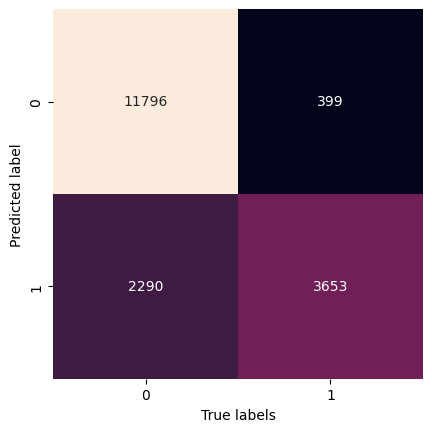

In [36]:
print("Confusion Matrix")
conf_mat = confusion_matrix(y_test, customized_predictions)

# Draw heatmap using confusion matrix
sns.heatmap(conf_mat, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True labels')
plt.ylabel('Predicted label');

## Conclusions